In [1215]:
from igraph import *
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import numpy as np
import re
import timeit

import igraph
import networkx as nx
import pandas as pd
import math


In [1216]:
def PreserveLargestConnectedGraph(G):
    Max = set()
    for S in list(nx.connected_components(G)):
        if len(S) > len(Max):
            G.remove_nodes_from(Max)
            Max = S
        else:
            G.remove_nodes_from(S)
    return G

In [1217]:
raw_data = pd.read_csv('../data/Contact-diaries-network_data_2013.csv',names=['userID', 'friendID','weight'])

In [1218]:
print(raw_data)

     userID  friendID  weight
0         3        28       2
1         3       106       1
2         3       147       4
3         3       177       1
4         3       295       4
..      ...       ...     ...
497    1828      1237       1
498    1828      1295       1
499    1828      1412       1
500    1828      1423       2
501    1828      1594       4

[502 rows x 3 columns]


In [1219]:
len(pd.unique(raw_data['userID']))

119

In [1220]:
G = nx.Graph()
subset =raw_data#[raw_data['weight']==1]
data = [(userID, friendID) for userID, friendID in zip(subset['userID'], subset['friendID'])]
G.add_edges_from(data)

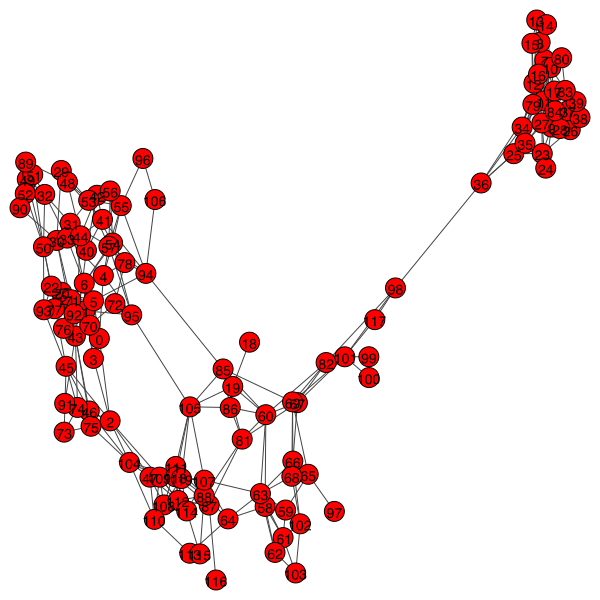

In [1221]:
# original graph
g= igraph.Graph.from_networkx(G)
igraph.plot(g,vertex_label=range(g.vcount()))

In [1222]:
# add weights to the graph
for i in range(g.ecount()):
    #print(i)
    if len(raw_data.loc[(raw_data['userID']==g.vs[g.es[i].source]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].target]['_nx_name'])]['weight'].values)>0:
        g.es[i]['weight'] = raw_data.loc[(raw_data['userID']==g.vs[g.es[i].source]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].target]['_nx_name'])]['weight'].values[0]
    elif len(raw_data.loc[(raw_data['userID']==g.vs[g.es[i].target]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].source]['_nx_name'])]['weight'].values)>0:
        g.es[i]['weight'] = raw_data.loc[(raw_data['userID']==g.vs[g.es[i].target]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].source]['_nx_name'])]['weight'].values[0]

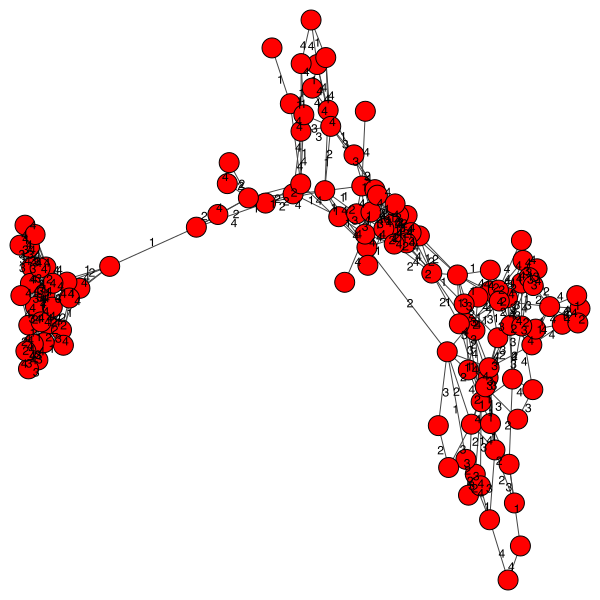

In [1223]:
igraph.plot(g,edge_label=g.es['weight'])

In [1224]:
g.vcount()

120

In [1225]:
g.ecount()

348

In [1226]:
import random

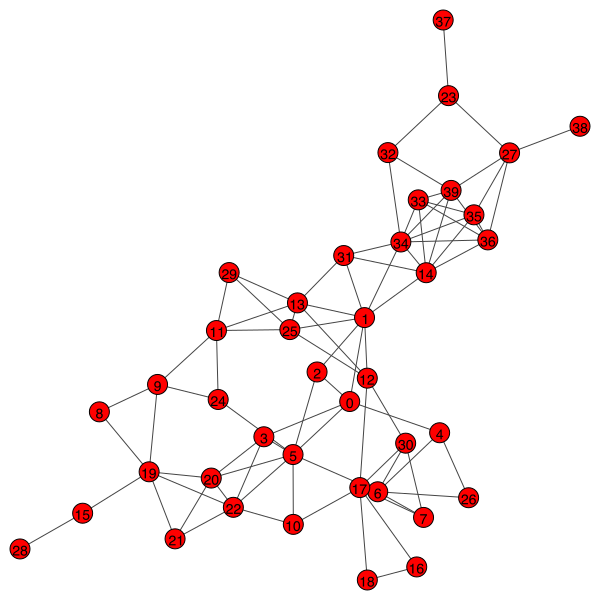

In [1227]:
G1 = nx.Graph()
while True:
    G1 = nx.subgraph(G,random.sample(list(G.nodes),90))
    G1 = nx.Graph(G1)
    G1 = PreserveLargestConnectedGraph(G1)
    if 40 <= nx.number_of_nodes(G1) <= 50:
        break
g1 = igraph.Graph.from_networkx(G1)
igraph.plot(g1,vertex_label=range(g1.vcount()))

In [1228]:
g1.vcount()

40

In [1229]:
g1.ecount()

84

In [1230]:
print(G1)

Graph with 40 nodes and 84 edges


In [1231]:
#define the model for Node Location Design

In [1232]:
N=g1.vcount()

In [1233]:
N

In [1234]:
# constants
# cost of connecting area i to possible location j
# pre-calculated value, by different topology
cost_connect = g1.distances()
cost_open = np.ones(N)*10

In [1235]:
for i in range(N):
    for j in range(N):
        if cost_connect[i][j]>1:
            cost_connect[i][j] = 999#math.inf
        if cost_connect[i][j] ==1:
            user_id = g1.vs[i]['_nx_name']
            friend_id = g1.vs[j]['_nx_name']
            #print(i,j,user_id,friend_id)
            if len(raw_data.loc[(raw_data['userID']==user_id)&(raw_data['friendID']==friend_id)])>0:
                cost_connect[i][j] = raw_data.loc[(raw_data['userID']==user_id)&(raw_data['friendID']==friend_id)]['weight'].values[0]
            elif len(raw_data.loc[(raw_data['userID']==friend_id)&(raw_data['friendID']==user_id)])>0:
                cost_connect[i][j] =raw_data.loc[(raw_data['userID']==friend_id)&(raw_data['friendID']==user_id)]['weight'].values[0]

123

In [1236]:
count=0
for i in range(N):
    for j in range(N):
        if 999 > cost_connect[i][j] > 1:
            #print(cost_connect[i][j])
            count+=1

In [1237]:
count

In [1238]:
# # Creates a list of tuples containing all the possible routes for nodes
# Routes = [(i, j) for i in range(N) for j in range(N)]

u(0,_0)

In [1239]:
# Define the model
model = LpProblem(name="node-location", sense=LpMinimize)
# Define the decision variables
u = {(i,j): LpVariable(name=f"u{(i,j)}", cat='Binary') for i in range(N) for j in range(N)}
# define decay index
epsilon = 2
# Define the node type variables
S = {i: LpVariable(name=f"S{i}", cat='Binary')for i in range(N)}
a = {i: LpVariable(name=f"a{i}", cat='Binary')for i in range(N)}
b = {i: LpVariable(name=f"b{i}", cat='Binary')for i in range(N)}
c = {i: LpVariable(name=f"c{i}", cat='Binary')for i in range(N)}
#Define the connect access variables
Sa = {(i,j): LpVariable(name=f"Sa{i,j}", cat='Binary')for i in range(N) for j in range(N)}
ab = {(i,j): LpVariable(name=f"ab{i,j}", cat='Binary')for i in range(N) for j in range(N)}
bc = {(i,j): LpVariable(name=f"bc{i,j}", cat='Binary')for i in range(N) for j in range(N)}


list

In [1240]:
u[0,0]

In [1241]:
type(cost_connect)

In [1242]:
#add objective function first
model += (
    lpSum(Sa[i,j]*cost_connect[i][j] +
          epsilon*ab[i,j]*cost_connect[i][j] +
          epsilon*epsilon*bc[i,j]*cost_connect[i][j] for i in range(N) for j in range(N))
    +lpSum(cost_open[i]*S[i] for i in range(N)),
    'Sum of open and connect cost',
)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/54/b46qlvhj6s50qkyccs51rmk80000gn/T/6517ec5bfa084a3d97af5bbc283edf81-pulp.lp
 -o /var/folders/54/b46qlvhj6s50qkyccs51rmk80000gn/T/6517ec5bfa084a3d97af5bbc283edf81-pulp.sol
Reading problem data from '/var/folders/54/b46qlvhj6s50qkyccs51rmk80000gn/T/6517ec5bfa084a3d97af5bbc283edf81-pulp.lp'...
11360 rows, 6560 columns, 29160 non-zeros
6560 integer variables, all of which are binary
21187 lines were read
GLPK Integer Optimizer 5.0
11360 rows, 6560 columns, 29160 non-zeros
6560 integer variables, all of which are binary
Preprocessing...
1560 hidden covering inequaliti(es) were detected
120 constraint coefficient(s) were reduced
11280 rows, 6520 columns, 28880 non-zeros
6520 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  3.900e+01  ratio =  3.900e+01
GM: min|aij| =  4.002e-01  max|aij| =  2.499e+00  ratio =  6.245e+00
EQ: min|aij| =  1.601e-01  max|a

In [1243]:
#Add constraints
for j in range(N):
    model += (
        lpSum(u[i,j] for i in range(N)) == 1-S[j],
        f"connected constraints_{j}",
    )

for i in range(N):
    for j in range(N):
            model += (
                u[i,j] <= Sa[i,j]+ab[i,j]+bc[i,j],
                f'no connection across different casade or node constraint_{i,j}',
            )
for i in range(N):
    for j in range(N):
            model += (
                Sa[i,j] <= S[i],
                f'S a first connection constraint_{i,j}',
            )

for i in range(N):
    for j in range(N):
            model += (
                Sa[i,j] <= a[j],
                f'S a second connection constraint_{i,j}',
            )
            
for i in range(N):
    for j in range(N):
            model += (
                ab[i,j] <= a[i],
                f'a b first connection constraint_{i,j}',
            )
for i in range(N):
    for j in range(N):
            model += (
                ab[i,j] <= b[j],
                f'a b second connection constraint_{i,j}',
            )
            
for i in range(N):
    for j in range(N):
            model += (
                bc[i,j] <= b[i],
                f'b c first connection constraint_{i,j}',
            )
for i in range(N):
    for j in range(N):
            model += (
                bc[i,j] <= c[j],
                f'b c second connection constraint_{i,j}',
            )
            
            
for i in range(N):
     model += (
        u[i,i] == 0,
        f"node can not connect to it self constraints_{i}",
    )
for i in range(N):
     model += (
        lpSum(u[i,j] for j in range(N)) <=(S[i]+a[i]+b[i])*N,
        f"node S capacity constraints_{i}",
    )
# for i in range(N):
#      model += (
#         lpSum(u[i,j] for j in range(N)) <=(a[i])*N,
#         f"node a capacity constraints_{i}",
#     )
for i in range(N):
     model += (
        S[i]+a[i]+b[i]+c[i] == 1,
        f"node type constraints_{i}",
    )
# model += (
#         lpSum(S[i] for i in range(N)) >=1,
#         f"make sure at lease one Source node constraints_{i}",
# )

status: 1, Optimal
objective: 144.0


In [1244]:
# Solve the optimization problem
start = timeit.default_timer()
status = model.solve()
stop = timeit.default_timer()
print('Time: ', stop - start)

u(0,_3): 1
u(1,_0): 1
u(1,_2): 1
u(5,_24): 1
u(6,_4): 1
u(6,_5): 1
u(6,_7): 1
u(6,_26): 1
u(6,_30): 1
u(13,_1): 1
u(13,_11): 1
u(13,_12): 1
u(13,_25): 1
u(13,_29): 1
u(13,_31): 1
u(15,_28): 1
u(16,_17): 1
u(16,_18): 1
u(17,_10): 1
u(19,_8): 1
u(19,_9): 1
u(19,_15): 1
u(19,_20): 1
u(19,_22): 1
u(22,_21): 1
u(23,_32): 1
u(23,_37): 1
u(27,_23): 1
u(27,_35): 1
u(27,_36): 1
u(27,_38): 1
u(27,_39): 1
u(31,_14): 1
u(35,_34): 1
u(39,_33): 1


In [1245]:
# Get the results
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

{(0, 3),
 (1, 0),
 (1, 2),
 (5, 24),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 26),
 (6, 30),
 (13, 1),
 (13, 11),
 (13, 12),
 (13, 25),
 (13, 29),
 (13, 31),
 (15, 28),
 (16, 17),
 (16, 18),
 (17, 10),
 (19, 8),
 (19, 9),
 (19, 15),
 (19, 20),
 (19, 22),
 (22, 21),
 (23, 32),
 (23, 37),
 (27, 23),
 (27, 35),
 (27, 36),
 (27, 38),
 (27, 39),
 (31, 14),
 (35, 34),
 (39, 33)}

In [1246]:
#print connection
selected_edge_set = set()
for var in u.values():
    if var.value() == 1:
        print(f"{var.name}: {var.value()}")
        selected_edge_set.add((int(re.findall(r'\d+',var.name)[0]),int(re.findall(r'\d+',var.name)[1])))
        #print(re.findall(r'\d+',var.name))

S6: 1
S13: 1
S16: 1
S19: 1
S27: 1


In [1247]:
selected_edge_set

0 [1, 2, 3, 4, 5]
1 [0, 2, 12, 13, 14, 25, 31, 34]
2 [0, 1, 5]
3 [0, 5, 20, 22]
4 [0, 6, 26]
5 [0, 2, 3, 6, 10, 20, 22, 24]
6 [4, 5, 7, 26, 30]
7 [6, 17, 30]
8 [9, 19]
9 [8, 11, 19, 24]
10 [5, 17, 22]
11 [9, 13, 24, 25, 29]
12 [1, 13, 17, 25, 30]
13 [1, 11, 12, 25, 29, 31]
14 [1, 31, 33, 34, 35, 36, 39]
15 [19, 28]
16 [17, 18]
17 [7, 10, 12, 16, 18, 30]
18 [16, 17]
19 [8, 9, 15, 20, 21, 22]
20 [3, 5, 19, 21, 22]
21 [19, 20, 22]
22 [3, 5, 10, 19, 20, 21]
23 [27, 32, 37]
24 [5, 9, 11]
25 [1, 11, 12, 13, 29]
26 [4, 6]
27 [23, 35, 36, 38, 39]
28 [15]
29 [11, 13, 25]
30 [6, 7, 12, 17]
31 [1, 13, 14, 34]
32 [23, 34, 39]
33 [14, 34, 35, 36, 39]
34 [1, 14, 31, 32, 33, 35, 36, 39]
35 [14, 27, 33, 34, 36]
36 [14, 27, 33, 34, 35, 39]
37 [23]
38 [27]
39 [14, 27, 32, 33, 34, 36]


In [1248]:
b[1]

{6, 13, 16, 19, 27}

In [1249]:
#print open node:
selected_v_set = set()
for var in S.values():
    if var.value() == 1:
        print(f"{var.name}: {var.value()}")
        selected_v_set.add(int(re.findall(r'\d+',var.name)[0]))

31 14
6 30
39 33
19 9
23 37
1 0
19 15
13 11
6 5
13 29
6 26
19 8
1 2
5 24
13 1
19 20
6 4
27 39
27 36
6 7
16 18
13 25
13 31
15 28
35 34
22 21
17 10
0 3
27 23
23 32
19 22
13 12
27 35
27 38
16 17


In [1250]:
for i in range(g1.vcount()):
    print(i, g1.neighbors(i))


{6: 5, 13: 6, 16: 2, 19: 5, 27: 5}

In [1251]:
selected_v_set

In [1252]:
selected_v_neighbour_number = {}
for item in selected_v_set:
    selected_v_neighbour_number[item] = 0
for item in selected_edge_set:
    print(item[0],item[1])
    if item[0] in selected_v_neighbour_number:
        selected_v_neighbour_number[item[0]]+=1

In [1253]:
selected_v_neighbour_number

6 0
13 1
16 2
19 3
27 4


In [1254]:
#g.get_eid(item[0], item[1])

{6: 'blue', 13: 'green', 16: 'yellow', 19: 'pink', 27: 'purple'}

In [1255]:
color_set = ['blue','green','yellow','pink','purple','red','orange']

{(0, 3),
 (1, 0),
 (1, 2),
 (5, 24),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 26),
 (6, 30),
 (13, 1),
 (13, 11),
 (13, 12),
 (13, 25),
 (13, 29),
 (13, 31),
 (15, 28),
 (16, 17),
 (16, 18),
 (17, 10),
 (19, 8),
 (19, 9),
 (19, 15),
 (19, 20),
 (19, 22),
 (22, 21),
 (23, 32),
 (23, 37),
 (27, 23),
 (27, 35),
 (27, 36),
 (27, 38),
 (27, 39),
 (31, 14),
 (35, 34),
 (39, 33)}

In [1256]:
color = dict()
count = 0
for item in selected_v_set:
    print(item,count)
    color[item]=color_set[count]
    count+=1
    count = count%len(color_set)

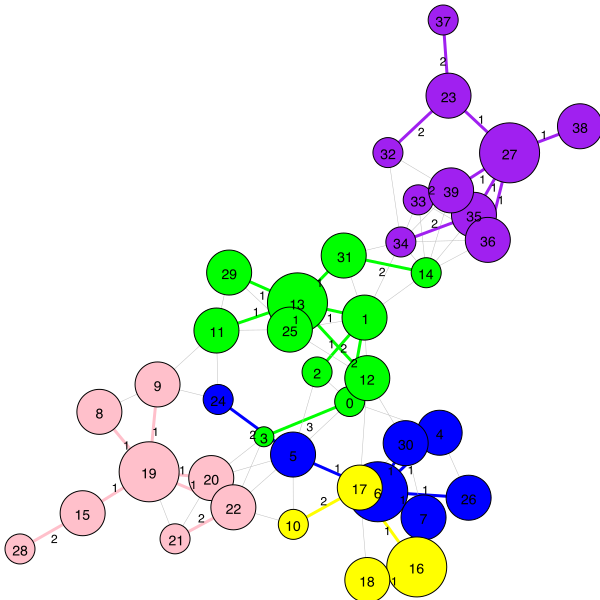

In [1257]:
color

In [1258]:
selected_edge_set

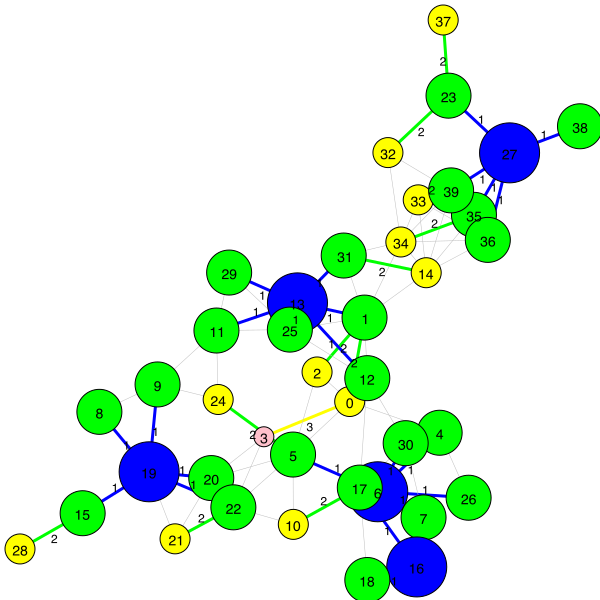

In [1259]:
# same information type has same color
g1.vs["color"] = "red"
g1.es["color"] = "grey"
g1.es['width'] = 0.5
g1.es['steps'] = ''
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if S[item[0]].value()==1:
        g1.vs[item[0]]["width"] = 60
        g1.vs[item[0]]['color'] = color[item[0]]
        g1.es[e]["color"] = g1.vs[item[0]]['color']
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 1
        g1.vs[item[1]]["width"] = 45
        g1.vs[item[1]]['color'] = g1.vs[item[0]]['color']
        
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if a[item[0]].value()==1:
        g1.es[e]["color"] = g1.vs[item[0]]['color']
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 2
        g1.vs[item[1]]["width"] = 30
        g1.vs[item[1]]['color'] = g1.vs[item[0]]['color']
        
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if b[item[0]].value()==1:
        g1.es[e]["color"] = g1.vs[item[0]]['color']
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 3
        g1.vs[item[1]]["width"] = 20
        g1.vs[item[1]]['color'] = g1.vs[item[0]]['color']

In [1260]:
igraph.plot(g1,vertex_label=range(g1.vcount()),edge_label=g1.es['steps'])

In [1261]:
# same casacade has same color
g1.vs["color"] = "red"
g1.es["color"] = "grey"
g1.es['width'] = 0.5
g1.es['steps'] = ''
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if S[item[0]].value()==1:
        g1.vs[item[0]]["width"] = 60
        g1.vs[item[0]]['color'] = color_set[0]
        g1.es[e]["color"] = color_set[0]
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 1
        g1.vs[item[1]]["width"] = 45
        g1.vs[item[1]]['color'] = color_set[1]
        
    elif a[item[0]].value()==1:
        g1.es[e]["color"] = color_set[1]
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 2
        g1.vs[item[1]]["width"] = 30
        g1.vs[item[1]]['color'] = color_set[2]
        
    elif b[item[0]].value()==1:
        g1.es[e]["color"] = color_set[2]
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 3
        g1.vs[item[1]]["width"] = 20
        g1.vs[item[1]]['color'] = color_set[3]

[set(), set(), set(), set()]

In [1262]:
igraph.plot(g1,vertex_label=range(g1.vcount()),edge_label=g1.es['steps'])

In [1263]:
for e in g1.es():
    e['weight'] = cost_connect[e.source][e.target]

In [1264]:
Nodes = [set() for i in range(4)]
Nodes

cost:  202.0
cost:  198.0
objective: 144.0


In [1265]:
from queue import PriorityQueue
extractNum = 3

# eigenvalue centrality
c = g1.evcent()
eigenvalue_centrality = {}
for node, centrality in enumerate(c):
    eigenvalue_centrality[node] = centrality

# between centrality
c = g1.betweenness()
between_centrality = {}
for node, centrality in enumerate(c):
    between_centrality[node] = centrality

c = g1.degree()
degree_centrality = {}
for node, centrality in enumerate(c):
    degree_centrality[node] = centrality

def algorithm1(graph, priority):
    S = set()
    a = set()
    b = set()
    c = set()
    ready = PriorityQueue()
    free = set([v.index for v in graph.vs])
    neighbors = {v.index: [] for v in graph.vs}
    for e in graph.es:
        v1 = e.source
        v2 = e.target
        neighbors[v1].append((v2,  e['weight']))
        neighbors[v2].append((v1,  e['weight']))
    edges = []

    if priority == 'EIGENVALUE':
        metric = [key for key, _ in sorted(eigenvalue_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'BETWEEN':
        metric = [key for key, _ in sorted(between_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'DEGREE':
        metric = [key for key, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        raise Exception("No such metric")
    idx = 0
    total_cost = 0
    #cost_open
    def add_neighbors(source, S, a, b, c, ready):
        for neighbor, cost in neighbors[source]:
            if neighbor not in S.union(a).union(b).union(c):
                if source in S:
                    ready.put((cost, source, neighbor))
                elif source in a:
                    ready.put((cost*epsilon, source, neighbor))
                elif source in b:
                    ready.put((cost*epsilon*epsilon, source, neighbor))
        return

    while len(S) + len(a) + len(b) + len(c) < graph.vcount():
        # set site nodes
        while idx < len(metric):

            source = metric[idx]
            if source in free: #S.union(a).union(b).union(c):
                total_cost += cost_open[source]
                S.add(source)
                free.remove(source)
                add_neighbors(source, S, a, b, c, ready)
                break
            else:
                idx += 1

        # extract min
        if not ready.empty():
            cost, source, neighbor = ready.get()
            if cost > cost_open[neighbor]:
                ready.put((cost, source, neighbor))
            while cost <= cost_open[neighbor]:
                if neighbor in free:

                    free.remove(neighbor)
                    edges.append((source, neighbor))

                    total_cost += cost
                    if source in S:
                        a.add(neighbor)
                        add_neighbors(neighbor, S, a, b, c, ready)
                    elif source in a:
                        b.add(neighbor)
                        add_neighbors(neighbor, S, a, b, c, ready)
                    elif source in b:
                        c.add(neighbor)
                        add_neighbors(neighbor, S, a, b, c, ready)
                    else:
                        raise Exception("source node wrong")
                if ready.empty():
                    break
                cost, source, neighbor = ready.get()


        # print("S: {}, a: {}, b: {}, c: {}".format(S, a, b, c))
    return S, a, b, c, edges, total_cost


In [1266]:
S, a, b, c, edges, total_cost = algorithm1(g1, 'EIGENVALUE')
print("cost: ", total_cost)
print(f"objective: {model.objective.value()}")


cost:  165.0
cost:  159.0
objective: 144.0


In [1267]:
def algorithm(graph, level, priority):
    Nodes = [set() for i in range(level)]
    ready = PriorityQueue()
    free = set([v.index for v in graph.vs])
    neighbors = {v.index: [] for v in graph.vs}
    for e in graph.es:
        v1 = e.source
        v2 = e.target
        neighbors[v1].append((v2,  e['weight']))
        neighbors[v2].append((v1,  e['weight']))
    edges = []

    if priority == 'EIGENVALUE':
        metric = [key for key, _ in sorted(eigenvalue_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'BETWEEN':
        metric = [key for key, _ in sorted(between_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'DEGREE':
        metric = [key for key, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        raise Exception("No such metric")
    idx = 0
    total_cost = 0

    def getAll():
        components = set()
        for s in Nodes:
            components = components.union(s)
        return components

    #cost_open
    def add_neighbors(source, Nodes, ready):
        for neighbor, cost in neighbors[source]:
            if neighbor not in getAll():
                for i in range(level - 1):
                    if source in Nodes[i]:
                        ready.put((cost*epsilon**i, source, neighbor))
        return

    while len(getAll()) < graph.vcount():
        # set site nodes
        while idx < len(metric):

            source = metric[idx]
            if source in free: #S.union(a).union(b).union(c):
                total_cost += cost_open[source]
                Nodes[0].add(source)
                free.remove(source)
                add_neighbors(source, Nodes, ready)
                break
            else:
                idx += 1

        # extract min
        if not ready.empty():
            cost, source, neighbor = ready.get()
            if cost > cost_open[neighbor]:
                ready.put((cost, source, neighbor))
            while cost <= cost_open[neighbor]:
                if neighbor in free:

                    free.remove(neighbor)
                    edges.append((source, neighbor))

                    total_cost += cost
                    for i in range(level - 1):
                        if source in Nodes[i]:
                            Nodes[i+1].add(neighbor)
                            add_neighbors(neighbor, Nodes, ready)

                    if i in Nodes[-1]:
                        raise Exception("source node wrong")
                if ready.empty():
                    break
                cost, source, neighbor = ready.get()

        # print(free)
        # print("S: {}, a: {}, b: {}, c: {}".format(Nodes[0], Nodes[1], Nodes[2], Nodes[3]))
    return Nodes, edges, total_cost

===============centrality tests==================
Updated Heuristic pagerank:  198.0
Updated Heuristic degree:  229.0
Updated Heuristic eigenvalue:  202.0
Updated Heuristic closeness:  229.0
Updated Heuristic pagerank:  159.0
Updated Heuristic degree:  177.0
Updated Heuristic eigenvalue:  165.0
Updated Heuristic closeness:  177.0
======================end=======================
objective: 144.0


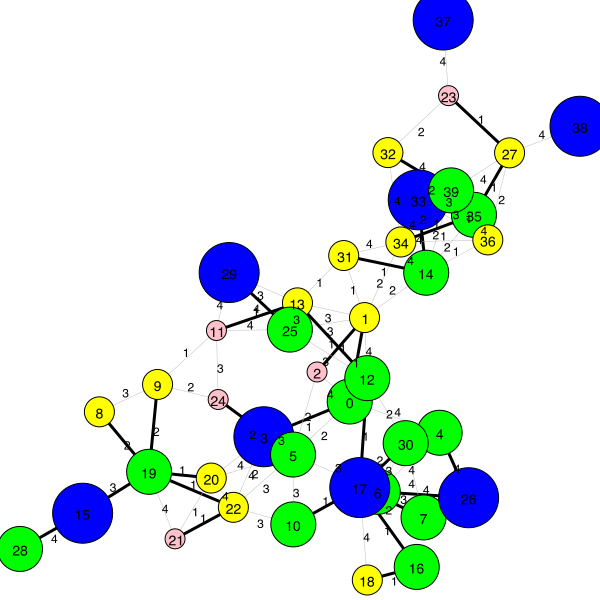

In [1268]:
Nodes, edges, total_cost = algorithm(g1, 4, 'EIGENVALUE')
print("cost: ", total_cost)

In [1269]:
def algorithm_with_update(graph, level, priority):
    Nodes = [set() for i in range(level)]
    ready = PriorityQueue()
    free = set([v.index for v in graph.vs])
    neighbors = {v.index: [] for v in graph.vs}
    for e in graph.es:
        v1 = e.source
        v2 = e.target
        neighbors[v1].append((v2,  e['weight']))
        neighbors[v2].append((v1,  e['weight']))
    edges = []

    if priority == 'EIGENVALUE':
        metric = [key for key, _ in sorted(eigenvalue_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'BETWEEN':
        metric = [key for key, _ in sorted(between_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'DEGREE':
        metric = [key for key, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        raise Exception("No such metric")
    idx = 0
    total_cost = 0

    def getAll():
        components = set()
        for s in Nodes:
            components = components.union(s)
        return components

    #cost_open
    def add_neighbors(source, Nodes, ready):
        for neighbor, cost in neighbors[source]:
            if neighbor not in getAll():
                for i in range(level - 1):
                    if source in Nodes[i]:
                        ready.put((cost*epsilon**i, source, neighbor))
            else:
                if neighbor in Nodes[0]:
                    continue
                pre = [x for x, y in edges if neighbor == y]
                if len(pre) != 1:
                    raise Exception("wrong connections")
                pre_cost = graph.es[graph.get_eid(pre[0], neighbor)]['weight']
                for i in range(level - 1):
                    if pre[0] in Nodes[i]:
                        pre_cost *= epsilon**i
                valid = False
                for i in range(level):
                    if source in Nodes[i] and cost*epsilon**i < pre_cost:
                        print("hello")
                        print(pre[0], pre_cost, source, neighbor, cost*epsilon**i)
                        valid = True
                        cost -= pre_cost
                        edges.remove((pre[0], neighbor))
                        ready.put((cost*epsilon**i, source, neighbor))
                    if neighbor in Nodes[i] and valid:
                        free.add(neighbor)
                        Nodes[i].remove(neighbor)
                pass
        return

    while len(getAll()) < graph.vcount():
        # set site nodes
        while idx < len(metric):

            source = metric[idx]
            if source in free: #S.union(a).union(b).union(c):
                total_cost += cost_open[source]
                Nodes[0].add(source)
                free.remove(source)
                add_neighbors(source, Nodes, ready)
                break
            else:
                idx += 1

        # extract min
        if not ready.empty():
            cost, source, neighbor = ready.get()
            if cost > cost_open[neighbor]:
                ready.put((cost, source, neighbor))
            while cost <= cost_open[neighbor]:
                if neighbor in free:
                    free.remove(neighbor)
                    edges.append((source, neighbor))

                    total_cost += cost
                    for i in range(level - 1):
                        if source in Nodes[i]:
                            Nodes[i+1].add(neighbor)
                            add_neighbors(neighbor, Nodes, ready)

                    if i in Nodes[-1]:
                        raise Exception("source node wrong")
                if ready.empty():
                    break
                cost, source, neighbor = ready.get()
        # print(free)
        # print(free)
        # print("S: {}, a: {}, b: {}, c: {}".format(Nodes[0], Nodes[1], Nodes[2], Nodes[3]))
    return Nodes, edges, total_cost


Time:  1.2740619170072023
Time:  0.0008590420038672164


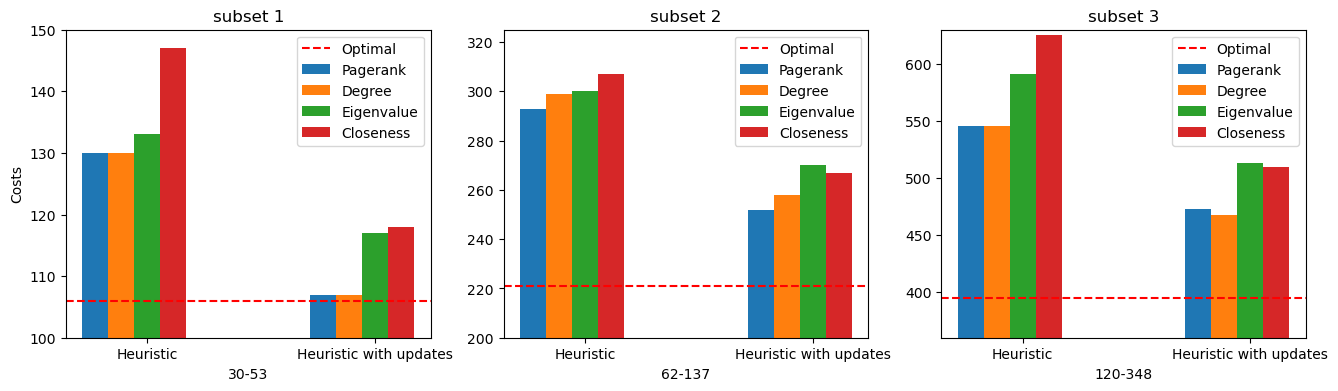

In [1270]:
Nodes, edges, total_cost = algorithm_with_update(g1, 4, 'EIGENVALUE')
print("cost: ", total_cost)
print(Nodes)

In [1270]:
print(S, a, b, c)
print(Nodes)

In [1213]:
 #g1.vs[1]1.vs["color"] = "red"
g1.es["color"] = "grey"
g1.es['width'] = 0.5
g1.es['steps'] = ''

for v in Nodes[0]:
    g1.vs[v]["width"] = 60
    g1.vs[v]['color'] = color_set[0]

for v in Nodes[1]:
    g1.vs[v]["width"] = 45
    g1.vs[v]['color'] = color_set[1]

for v in Nodes[2]:
    g1.vs[v]["width"] = 30
    g1.vs[v]['color'] = color_set[2]

for v in Nodes[3]:
    g1.vs[v]["width"] = 20
    g1.vs[v]['color'] = color_set[3]

for e in edges:
    g1.es[g1.get_eid(e[0], e[1])]['width'] = 3
    g1.es[g1.get_eid(e[0], e[1])]['color'] = 'black'


igraph.plot(g1,vertex_label=range(g1.vcount()),edge_label=g1.es['weight'])

Time:  0.45303437500842847
Time:  0.0006190839922055602


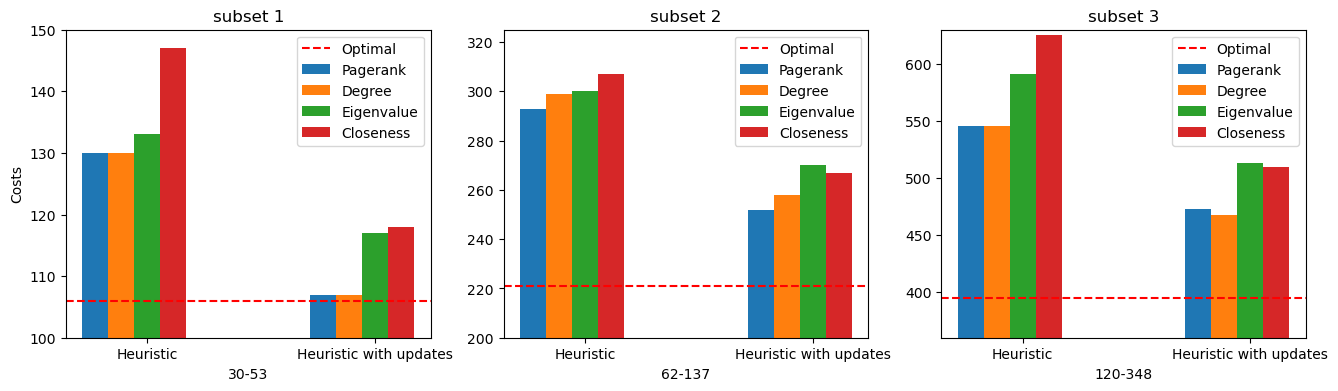

In [1214]:
#S[0].value()

In [1214]:
from datetime import datetime
current_time = datetime.now().strftime("%D_%H:%M:%S")
print("Current Time =", current_time)
with open('../result/experiment_result.txt','a') as f:
    f.write('___________________________________________________________________________________\n')
    f.write(current_time+'\n No.Edges:'+str(g1.ecount())+'\t No.Vertex:'+str(g1.vcount())+'\n')
    f.write(f"objective: {model.objective.value()}\n")
    f.write('Running time:'+str(stop - start)+'\n')
    f.write('Edge information\n')
    f.write('S:\n')
    for var in S.values():
        f.write (f"{var.name}: {var.value()}\t")
    f.write('\na:\n')
    for var in a.values():
        f.write (f"{var.name}: {var.value()}\t")
    f.write('\nb:\n')
    for var in b.values():
        f.write (f"{var.name}: {var.value()}\t")
    f.write('\nc:\n')
    for var in c.values():
        f.write (f"{var.name}: {var.value()}\t")
    f.write('\n Linked Node information\n')
    #for item in selected_edge_set:
    f.write(str(selected_edge_set))
